In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
import string

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('covid_tweets.csv',header=None)

In [5]:
df.columns

Int64Index([0, 1, 2], dtype='int64')

In [6]:
df.head(5)

,0,1,2
0,2022-03-12 13:05:16+00:00,1502631813961097218,b'RT @AIFoundation: #Inspiringstory of a small...
1,2022-03-12 08:31:07+00:00,1502562819606302727,b'3th COVID 19 booster vaccination.\nPure Pfiz...
2,2022-03-12 04:27:06+00:00,1502501414349656065,b'Pandemic 101: Essential facts and myths abou...
3,2022-03-12 04:17:47+00:00,1502499068815175684,"b""Unvaccinated MLB players won't be paid for m..."
4,2022-03-12 04:17:25+00:00,1502498974871089153,"b""Unvaccinated MLB players won't be allowed in..."


In [7]:
data = df[[2]]

In [8]:
data.head()

,2
0,b'RT @AIFoundation: #Inspiringstory of a small...
1,b'3th COVID 19 booster vaccination.\nPure Pfiz...
2,b'Pandemic 101: Essential facts and myths abou...
3,"b""Unvaccinated MLB players won't be paid for m..."
4,"b""Unvaccinated MLB players won't be allowed in..."


In [9]:
data.rename(columns={2 : 'tweet'}, inplace = True)

In [10]:
print(data.shape)

(2418, 1)


In [11]:
data.columns

Index(['tweet'], dtype='object')

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [13]:
def remove_tweet_handles(text):
    processed_text = ''
    for token in text.split(' '):
        if not token.startswith('@') and not token == 'RT':
            processed_text += token + ' '
        elif token.startswith('#'):
            token = token.replace('#', '')   # Removing # in the word
            processed_text += token + ' '
    return processed_text.strip()
        
data['Processed_tweet'] = data['tweet'].apply(remove_tweet_handles)

In [14]:
replace_words = {r"won't" : "will not",
                 r"can\'t": "can not",
                 r"n\'t"  : " not",
                 r"\'re"  : " are",
                 r"\'s"   : " is",
                 r"\'d"   : " would",
                 r"\'ll"  : " will",
                 r"\'t"   : " not",
                 r"\'ve"  : " have",
                 r"\'m"   : " am",
                 '\\r'    : ' ',
                 '\\"'    : ' ',
                 '\\n'    : ' '}

def remove_special_charcters(text):
    text = re.sub('[^A-Za-z0-9]+', ' ', text) #Removes Special Chaacters
    for key in replace_words.keys():
        text = re.sub(key, replace_words[key], text)
    return text
    
data['Processed_tweet'] = data['Processed_tweet'].apply(remove_special_charcters)

In [15]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['Processed_tweet'])

In [16]:
model = KMeans(n_clusters=4)
model.fit(X)

KMeans(n_clusters=4)

In [17]:
centroids = model.cluster_centers_.argsort()[:, ::-1]

names = vectorizer.get_feature_names()
for i in range(4):
    print("Cluster %d:" % i),
    for ind in centroids[i, :10]:
        print(' %s' % names[ind]),
    print

Cluster 0:
 xe2
 x80
 https
 xa6
 rt
 vaccine
 covid
 amp
 pfizer
 19
Cluster 1:
 xa4
 life
 xe0
 exploring
 hike
 biking
 pct
 thought
 hiking
 traveling
Cluster 2:
 xf0
 x9f
 xe0
 x91
 xb8
 x89
 rt
 xa4
 x98
 xe2
Cluster 3:
 harrowing
 insane
 25
 needs
 excess
 getvaccinated
 vaccinedeaths
 deaths
 age
 44


In [18]:
prediction = model.predict(X)
data['Sentiment'] = prediction

In [19]:
data.head()

,tweet,Processed_tweet,Sentiment
0,b'RT @AIFoundation: #Inspiringstory of a small...,b RT Inspiringstory of a small village and its...,0
1,b'3th COVID 19 booster vaccination.\nPure Pfiz...,b 3th COVID 19 booster vaccination nPure Pfize...,0
2,b'Pandemic 101: Essential facts and myths abou...,b Pandemic 101 Essential facts and myths about...,0
3,"b""Unvaccinated MLB players won't be paid for m...",b Unvaccinated MLB players won t be paid for m...,0
4,"b""Unvaccinated MLB players won't be allowed in...",b Unvaccinated MLB players won t be allowed in...,0


In [20]:
data['Sentiment'].value_counts()

0    2000
2     257
1     123
3      38
Name: Sentiment, dtype: int64

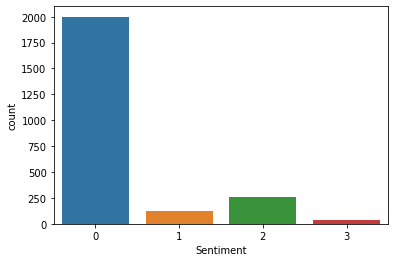

In [21]:
import seaborn as sns
ax=sns.countplot(data.Sentiment)

In [22]:
X.shape

(2418, 5526)

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, prediction, test_size=0.2, random_state=42)

In [24]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [25]:
from keras.preprocessing import sequence

In [26]:
x_train = sequence.pad_sequences(sequences=X_train.toarray())
x_test = sequence.pad_sequences(sequences=X_test.toarray())
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


x_train shape: (1934, 5526)
x_test shape: (484, 5526)


In [27]:
X.shape

(2418, 5526)

In [28]:
X_train.shape

(1934, 5526)

In [29]:
X_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
X_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical

In [31]:
trainy = to_categorical(y_train)
testy = to_categorical(y_test)

In [32]:
X_train.shape

(1934, 5526, 1)

In [33]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
model.fit(X_train, trainy, epochs=10, batch_size=8)


Epoch 1/10
242/242 [==============================] - 80s 329ms/step - loss: 0.8238 - accuracy: 0.8278
Epoch 2/10
242/242 [==============================] - 76s 312ms/step - loss: 0.6352 - accuracy: 0.8278
Epoch 3/10
242/242 [==============================] - 79s 328ms/step - loss: 0.6312 - accuracy: 0.8278
Epoch 4/10
242/242 [==============================] - 80s 329ms/step - loss: 0.6324 - accuracy: 0.8278
Epoch 5/10
242/242 [==============================] - 75s 310ms/step - loss: 0.6244 - accuracy: 0.8278
Epoch 6/10
242/242 [==============================] - 78s 323ms/step - loss: 0.6255 - accuracy: 0.8278
Epoch 7/10
242/242 [==============================] - 77s 319ms/step - loss: 0.6228 - accuracy: 0.8278
Epoch 8/10
242/242 [==============================] - 76s 315ms/step - loss: 0.6204 - accuracy: 0.8278
Epoch 9/10
242/242 [==============================] - 78s 324ms/step - loss: 0.6201 - accuracy: 0.8278
Epoch 10/10
242/242 [==============================] - 76s 315ms/step - l

In [36]:
_, accuracy = model.evaluate(X_test, testy)

16/16 [==============================] - 3s 155ms/step - loss: 0.6116 - accuracy: 0.8244


In [37]:
accuracy

0.8243801593780518

In [38]:
prediction = model.predict(X_test)

In [39]:
prediction =np.argmax(prediction, axis=1)

In [40]:
y_test,prediction

(array([0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2,
        0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 2, 3, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 3, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2,
        2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

tp, fn, fp, tn = confusion_matrix(y_test,prediction)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test,prediction)
print('Classification report : \n',matrix)

Outcome values : 
 [399   0   0   0] [21  0  0  0] [57  0  0  0] [7 0 0 0]
Classification report : 
               precision    recall  f1-score   support

           0       0.82      1.00      0.90       399
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        57
           3       0.00      0.00      0.00         7

    accuracy                           0.82       484
   macro avg       0.21      0.25      0.23       484
weighted avg       0.68      0.82      0.75       484

